# TensorFlow・Kerasのトレーニング♨

## 環境準備、共通的データ処理 編

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インストール](#インストール)
  - [インポート](#インポート)
  - [プロキシ設定](#プロキシ設定)
- [共通処理](#共通処理)
  - [勾配降下法アルゴリズムの選択](#勾配降下法アルゴリズムの選択)
  - [モデルの定義とコンパイル](#モデルの定義とコンパイル)
  - [モデルの学習と推論](#モデルの学習と推論モデルの保存と復元)
  - [モデルの保存と復元](#モデルの保存と復元)
  - [過学習の抑止](#過学習の抑止)

## 参考
開発基盤部会 Wiki
- データマイニング（DM）- Python - DL  
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20Python%20-%20DL

## 環境準備

### インストール

#### 基本的なライブラリ

In [ ]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install statsmodels

#### scikit-learn

In [ ]:
!pip install scikit-learn

#### tensorflow keras

##### アンイストール
バージョン不一致の問題が起きたら一度アンイストールする。

In [3]:
#!echo Y | pip uninstall keras
#!echo Y | pip uninstall tensorflow

##### tensorflow

###### CPU

In [ ]:
!pip install tensorflow

###### GPU

In [5]:
#!pip install tensorflow-gpu

In [6]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [7]:
#import tensorflow as tf
##tf.test.is_gpu_available()
#tf.config.list_physical_devices('GPU')

##### keras

In [ ]:
!pip install keras

#### opencv

In [ ]:
!pip install opencv-python

### インポート

#### 基本的なライブラリ

In [10]:
import io
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### scikit-learn

In [11]:
from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#### tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
print(tf.__version__)

#### keras

In [13]:
import keras
print(keras.__version__)

# モデル定義
from keras.models import Model, Sequential, model_from_json, load_model
from keras.layers import Dense, Input, Activation, Flatten, Dropout, LSTM
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.optimizers import SGD, Adam

# その他
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical

3.6.0


#### その他

In [14]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### プロキシ設定

In [15]:
import os
proxies = {
    "http": os.getenv("HTTP_PROXY"),
    "https": os.getenv("HTTPS_PROXY")
}

## 共通処理

### 勾配降下法アルゴリズムの選択
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E3%81%AE%E3%83%86%E3%82%AF%E3%83%8B%E3%83%83%E3%82%AF#ma318ba7

#### SGD
（Stochastic Gradient Descent）、確率的勾配降下法
- 勾配が最も急な向きに勾配を下る手法
- 学習率の調整が難しいため自動調整のアルゴリズムが必要。
- lr：学習率（0以上のfloat

In [ ]:
optimizer = optimizers.SGD(learning_rate=0.01)

#### MomentumSGD
- SGDに慣性（加速・減速）の概念を加えた最適化手法｡
- SGDのコードに「momentum」（慣性項の係数（0以上のF）を追加。
- 谷間での無駄な往復を減らし、早く収束するが、  
加速しているため、極小値付近で止まり難い。

In [17]:
optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.9)

#### NesterovAG
（Nesterov Accelerated Gradient）
- 極小値付近でブレーキをかける機能を加えたアルゴリズム
- [MomentumSGD](#MomentumSGD)のコードに「nesterov=True」を追加。

In [18]:
optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#### AdaGrad
- 動いた量が増えたら更新が緩やかにする。
- [NesterovAG](#NesterovAG)のブレーキ機能を学習率の減衰によって実現
- デフォルト・パラメタが推奨
  - lr ：学習率（0以上のfloat
  - epsilon：分母の最小値（0以上のfloat
  - decay ：学習率減衰（0以上のfloat

In [19]:
optimizer = optimizers.Adagrad()

In [20]:
optimizer = optimizers.Adagrad(learning_rate=0.01, epsilon=None, decay=0.0)

#### RMSprop
（Root Mean Square Propagation）
- [AdaGrad](#AdaGrad)の改良版
  - 学習率の減衰が穏やかになる機能を追加
  - 引数に「rho」（指数移動平均）を追加。
- 学習率以外はデフォルト・パラメタが推奨

In [21]:
optimizer = optimizers.RMSprop(learning_rate=0.001)

In [22]:
optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

#### AdaDelta
- [Adagrad](#Adagrad)の改良版の[RMSprop](#RMSprop)に､もうひと工夫加えたようなアルゴリズム
- デフォルト・パラメタが推奨

In [23]:
optimizer = optimizers.Adadelta()

In [24]:
optimizer = optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=None, decay=0.0)

#### Adam
（ADAptive Moment estimation）
- [MomentumSGD](#MomentumSGD)系の慣性項と[AdaGrad](#AdaGrad)系の学習率の  
両方の自動調整の機能を持ち合わせたアルゴリズム
- beta_1 ：MomentumSGDのmomentum
- beta_2 ：AdaGradのrho
- amsgrad：AMSGradを適用するかどうか。

In [25]:
optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

### モデルの定義とコンパイル
以下は、DNNによる回帰

#### モデルの定義

In [26]:
num = 13 # x_train.shape[1] # 入力ベクトルの要素数
model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(num,)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
])

#### モデルのコンパイル

In [27]:
model.compile(loss='mse', optimizer=Adam(), metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

### モデルの学習と推論

#### データ

In [28]:
url = 'https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?plugin=attach&pcmd=open&file=Boston.csv&refer=FrontPage'
res = requests.get(url) # , verify=False, proxies=proxies) # プロキシ
df = pd.read_csv(io.BytesIO(res.content), encoding='utf-8', sep=",")

df=df.drop('Unnamed: 0',axis=1)

x_org = np.array(df.drop(['medv'], axis=1))
y_org = np.array(df.loc[:, ['medv']])

mean = x_org.mean(axis=0)
std = x_org.std(axis=0)
x = (x_org - mean) / std

x_train, x_test, y_train, y_test = train_test_split(x, y_org, test_size = 0.3, random_state = 0)

#### 学習

In [29]:
batch_size = 20
n_epoch = 200
hist = model.fit(x_train, y_train,
                 batch_size=batch_size,
                 epochs=n_epoch,
                 validation_data=(x_test, y_test),
                 verbose=1)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 570.2369 - mae: 21.9684 - val_loss: 476.3999 - val_mae: 19.8117
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 446.0331 - mae: 19.4022 - val_loss: 369.5757 - val_mae: 16.9176
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 347.4999 - mae: 16.3055 - val_loss: 231.3416 - val_mae: 12.8928
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 213.9186 - mae: 12.3869 - val_loss: 107.8680 - val_mae: 8.2233
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 93.7397 - mae: 7.4348 - val_loss: 62.1478 - val_mae: 5.9538
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.9747 - mae: 5.3696 - val_loss: 47.6320 - val_mae: 5.0964
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.4936 - mae: 4.1588 - val_loss: 38.6712 - val_mae: 4.5598
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.6928 - mae: 3.7132 - val_loss: 33.6963 - val_mae: 4.2582
Epoch 9/200
18/18 ━━━━━━━━━━━━━━

#### 推論

In [30]:
y_pred = model.predict(x)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


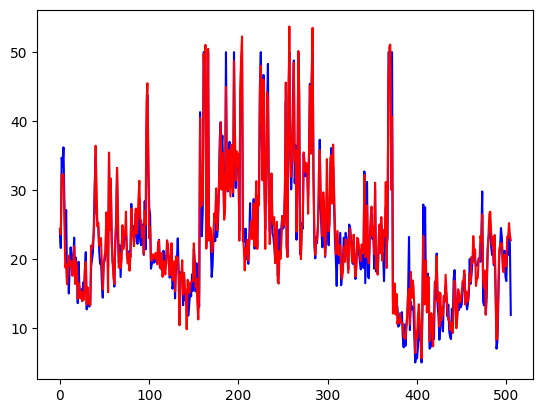

In [31]:
plt.plot(y_org, color='blue') # 実測値
plt.plot(y_pred, color='red') # 予測値
plt.show()

### モデルの保存と復元

#### モデルの保存

In [32]:
model.save('../work/dnn.keras', include_optimizer=False)

#### モデルの復元

In [33]:
model = load_model('../work/dnn.keras', compile=False)

###### 評価

### モデルの評価

#### 学習履歴を表示

In [34]:
# loss
def plot_history_loss(hist):
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()
    
#hist = model.fit(x_train, ...
#plot_history_loss(hist)

In [35]:
# mae
def plot_history_mae(hist):
    plt.plot(hist.history['mae'],label="mae for training")
    plt.plot(hist.history['val_mae'],label="mae for validation")
    plt.title('model mae')
    plt.xlabel('epoch')
    plt.ylabel('mae')
    plt.legend(loc='best')
    plt.show()
    
#hist = model.fit(x_train, ...
#plot_history_mae(hist)

In [36]:
# accuracy
def plot_history_acc(hist):
    plt.plot(hist.history['accuracy'],label="accuracy for training")
    plt.plot(hist.history['val_accuracy'],label="accuracy for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='upper right')
    plt.show()
    
#hist = model.fit(x_train, ...
#plot_history_acc(hist)

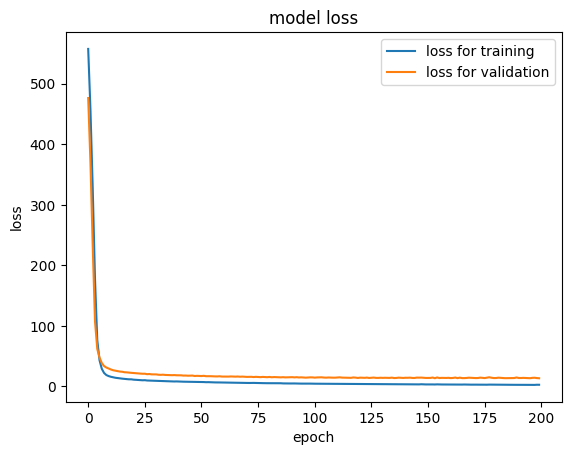

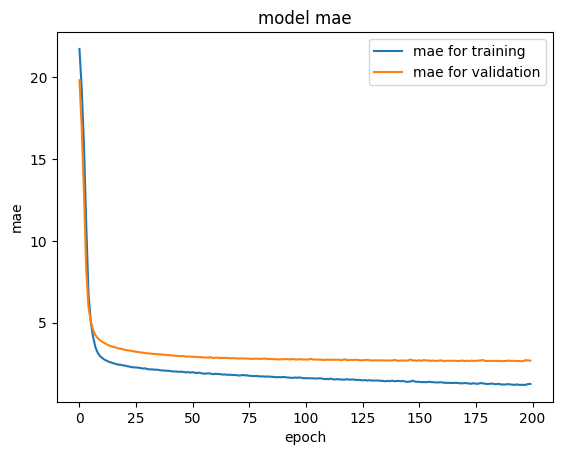

In [37]:
plot_history_loss(hist)
plot_history_mae(hist)
#plot_history_acc(hist)

### 過学習の抑止

#### 早期終了（early stopping）

##### EarlyStoppingクラス
- monitor  
監視する値
- patience  
指定エポック数の間、改善がない場合、学習を停止
- mode  
収束判定（auto: 自動, min: 最小時, max: 最大時）
- verbose  
標準出力で通知をするか否か

In [38]:
es = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=0)
#hist = model.fit(..., callbacks=[es]) # EarlyStoppingを適用

##### ModelCheckpointクラス
検証誤差が最も低い状態のモデルを保存
- monitor  
監視する値（デフォルト: val_loss）
- mode  
収束判定（auto: 自動, min: 最小時, max: 最大時）
- verbose  
標準出力で通知をするか否か
- filepath  
モデルを保存するファイルパス
- save_best_only  
最良の状態のモデルのみを保存するかどうか（bool）

In [39]:
mc = ModelCheckpoint(monitor='val_loss', mode='min', verbose=1, filepath='./dl4.keras', save_best_only=True)
#hist = model.fit(..., callbacks=[mc]) # ModelCheckpointを適用

#### ドロップアウト（Dropout）
最終層の前に以下を追加。

In [40]:
# 無効化比率0.5のDropout
#model.add(Dropout(rate=0.5))

#### バッチ正規化（Batch Normalization）
- DNNの場合、全結合層と活性化関数の間に
- CNNの場合、「全結合層 or 畳み込み層」と活性化関数の間に以下を追加。

In [41]:
#model.add(BatchNormalization())